In [1]:
import glob, os, sys, toml, pickle, time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from os import path

from sklearn.preprocessing import OneHotEncoder
from multiprocessing import Pool, cpu_count
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor



path_MOASMO = '/glade/u/home/guoqiang/CTSM_repos/ctsm_optz/MO-ASMO/src/'
sys.path.append(path_MOASMO)
import gp
import NSGA2


import os, sys, subprocess, time, toml

sys.path.append("/glade/u/home/mozhgana/mywork/model_calibration/src/moasmo_test/")
sys.path.append("/glade/u/home/mozhgana/mywork/model_calibration/src/moasmo_test/allbasin_emulator")
from MOASMO_parameter_allbasin_emulator import *
from multiprocessing import Pool


sys.path.append("/glade/u/home/guoqiang/CTSM_repos/ctsm_optz/MO-ASMO/src")
# import NSGA2


from MOASMO_parameters import *

import torch
import torch.nn as nn
import torch.optim as optim


import torch
import torch.nn as nn
import joblib
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score

# Load data

In [2]:
infile_basin_info = '/glade/work/guoqiang/CTSM_CAMELS/data_mesh_surf/HillslopeHydrology/CAMELS_level1_basin_info.csv'
infile_param_info = '/glade/u/home/mozhgana/mywork/model_calibration/src/moasmo_test/param_file_tpl.csv'
infile_attr_foruse = '/glade/u/home/guoqiang/CTSM_repos/CTSM_calibration/data/camels_attributes_table_TrainModel.csv'
inpath_moasmo = '/glade/campaign/cgd/tss/people/mozhgana/projects/SUMMA_Calib'

CV=1
ncpus = 1
iterend = 1
outpathname = 'LSE_spaceCV_PredictParam_4X_ann'
suffix = f'LSEspaceCV_ann_{CV}'
objfunc = 'normKGE'
numruns = 100


In [3]:
CV=1
outpath = '/glade/campaign/cgd/tss/people/mozhgana/projects/SUMMA_Calib/LSE_spaceCV_PredictParam'
# divide into train/test index
outfile = f'{outpath}/train_test_CV_indices.npz'
if os.path.isfile(outfile):
    dtmp = np.load(outfile, allow_pickle=True)
    train_indices, test_indices = dtmp['train_indices'], dtmp['test_indices']

train_index= train_indices[CV-1]
test_index= test_indices[CV-1]

In [4]:
suffix_defa_source = 'LSEnormKGE'

outpath = f"{inpath_moasmo}/{outpathname}"
os.makedirs(outpath, exist_ok=True)

# Load data: same for all iterations
df_basin_info = pd.read_csv(infile_basin_info)
df_basin_info.index = np.arange(len(df_basin_info))
all_index = np.arange(len(df_basin_info))

test_index = np.setdiff1d(all_index, train_index)

# information for all basins
df_param_info = pd.read_csv(infile_param_info)

file_defa_param = f'{outpath}/camels_summa_defa_param_train_{suffix}.csv'
df_param_defa_train = read_allbasin_defa_params(infile_param_info, file_defa_param, Basin_list, train_index)

file_defa_param = f'{outpath}/camels_summa_defa_param_test_{suffix}.csv'
df_param_defa_test = read_allbasin_defa_params(infile_param_info, file_defa_param, Basin_list, test_index)

file_param_lb = f'{outpath}/camels_summa_all_param_lb_train_{suffix}.gz'
file_param_ub = f'{outpath}/camels_summa_all_param_ub_train_{suffix}.gz'

df_param_lb_train, df_param_ub_train = load_basin_param_bounds(inpath_moasmo, df_param_defa_train, file_param_lb, file_param_ub)

file_param_lb = f'{outpath}/camels_summa_all_param_lb_test_{suffix}.gz'
file_param_ub = f'{outpath}/camels_summa_all_param_ub_test_{suffix}.gz'
df_param_lb_test, df_param_ub_test = load_basin_param_bounds(inpath_moasmo, df_param_defa_test, file_param_lb, file_param_ub)


file_camels_attribute = f'{outpath}/camels_basin_attribute_train_{suffix}.pkl'
df_att_train = read_camels_attributes(infile_basin_info, file_camels_attribute, train_index)
file_camels_attribute = f'{outpath}/camels_basin_attribute_test_{suffix}.pkl'
df_att_test = read_camels_attributes(infile_basin_info, file_camels_attribute, test_index)

df_att_foruse = pd.read_csv(infile_attr_foruse)
useattrs = list(df_att_foruse[df_att_foruse['att_Xie2021'].values]['Attribute_text'].values)
print("The number of attributes used:", len(useattrs))
print(useattrs)


suffixtest = suffix+'test'

# Load data: outputs from each iteration from training basins
for iter in range(0, iterend):
    file_all_param = f'{outpath}/camels_summa_all_param_train_{suffix}_iter{iter}.gz'
    file_all_metric = f'{outpath}/camels_summa_all_metric_train_{suffix}_iter{iter}.gz'
    file_all_basinid = f'{outpath}/camels_summa_all_basinid_train_{suffix}_iter{iter}.gz'

    file_all_param_test = f'{outpath}/camels_summa_all_param_test_{suffix}_iter{iter}.gz'
    file_all_metric_test = f'{outpath}/camels_summa_all_metric_test_{suffix}_iter{iter}.gz'
    file_all_basinid_test = f'{outpath}/camels_summa_all_basinid_test_{suffix}_iter{iter}.gz'

    if iter == 0:

        df_param_i, df_metric_i, df_basinid_i = load_all_basin_params_metrics(inpath_moasmo, infile_param_info, df_param_defa_train,
                                                                              df_basin_info, iter, file_all_param,
                                                                              file_all_metric, file_all_basinid,
                                                                              train_index, suffix_defa_source)
    
        df_param_i_test, df_metric_i_test, df_basinid_i_test = load_all_basin_params_metrics(inpath_moasmo, infile_param_info, df_param_defa_test,
                                                                              df_basin_info, iter, file_all_param_test,
                                                                              file_all_metric_test, file_all_basinid_test,
                                                                              test_index, suffix_defa_source)
    else:
        df_param_i, df_metric_i, df_basinid_i = load_all_basin_params_metrics(inpath_moasmo, infile_param_info, df_param_defa_train,
                                                                              df_basin_info, iter, file_all_param,
                                                                              file_all_metric, file_all_basinid,
                                                                              train_index, suffix)
    
        df_param_i_test, df_metric_i_test, df_basinid_i_test = load_all_basin_params_metrics(inpath_moasmo, infile_param_info, df_param_defa_test,
                                                                              df_basin_info, iter, file_all_param_test,
                                                                              file_all_metric_test, file_all_basinid_test,
                                                                              test_index, suffixtest)

    df_basinid_i['iter'] = iter
    df_basinid_i_test['iter'] = iter

    if iter == 0:
        df_param = df_param_i
        df_metric = df_metric_i
        df_basinid = df_basinid_i
        
        df_param_test = df_param_i_test
        df_metric_test = df_metric_i_test
        df_basinid_test = df_basinid_i_test
    else:
        df_param = pd.concat([df_param, df_param_i])
        df_metric = pd.concat([df_metric, df_metric_i])
        df_basinid = pd.concat([df_basinid, df_basinid_i])
        
        df_param_test = pd.concat([df_param_test, df_param_i_test])
        df_metric_test = pd.concat([df_metric_test, df_metric_i_test])        
        df_basinid_test = pd.concat([df_basinid_test, df_basinid_i_test])

df_param = df_param.apply(pd.to_numeric, errors='coerce')
df_param_test = df_param_test.apply(pd.to_numeric, errors='coerce')


df_param.index = np.arange(len(df_param))
df_metric.index = np.arange(len(df_metric))
df_basinid.index = np.arange(len(df_basinid))

df_param_test.index = np.arange(len(df_param_test))
df_metric_test.index = np.arange(len(df_metric_test))
df_basinid_test.index = np.arange(len(df_basinid_test))


index = np.isnan(np.sum(df_metric.values, axis=1) + np.sum(df_param.values, axis=1))
df_param = df_param[~index]
df_metric = df_metric[~index]
df_basinid = df_basinid[~index]

index_test = np.isnan(np.sum(df_metric_test.values, axis=1) + np.sum(df_param_test.values, axis=1))
df_param_test = df_param_test[~index_test]
df_metric_test = df_metric_test[~index_test]
df_basinid_test = df_basinid_test[~index_test]


df_param.index = np.arange(len(df_param))
df_metric.index = np.arange(len(df_metric))
df_basinid.index = np.arange(len(df_basinid))

df_param_test.index = np.arange(len(df_param_test))
df_metric_test.index = np.arange(len(df_metric_test))
df_basinid_test.index = np.arange(len(df_basinid_test))


print('Number of nan samples:', np.sum(index))
print("Number of original parameter sets:", len(index))
print("Number of final parameter sets:", len(df_param))


# One-hot encoding for categorical attributes
df_att = pd.concat([df_att_train, df_att_test])
df_att.index = np.arange(len(df_att))
df_att_use = df_att[useattrs + ["hru_id"]]

for att in useattrs:
    if df_att_use[att].dtype == "object":
        print('Convert', att, 'to one-hot encoding')
        enc = OneHotEncoder(sparse_output=False)
        enc.fit(df_att_use[[att]])
        encnames = [att + "_" + str(i) for i in range(len(enc.categories_[0]))]
        print('New columns:', encnames)
        df_enc = pd.DataFrame(enc.transform(df_att_use[[att]]), columns=encnames)
        df_att_use = pd.concat([df_att_use, df_enc], axis=1)
        df_att_use = df_att_use.drop([att], axis=1)

df_att_use_train = df_att_use[:len(df_att_train)]
df_att_use_test = df_att_use[len(df_att_train):]
df_att_use_train.index = np.arange(len(df_att_use_train))
df_att_use_test.index = np.arange(len(df_att_use_test))

useattrs = list(df_att_use_train.columns)
useattrs.remove('hru_id')

# Prepare model input and output
df_input = df_param.copy()
df_input["hru_id"] = df_basinid["basin_name"]
df_input = df_input.merge(df_att_use_train[useattrs + ["hru_id"]], on="hru_id", how="left")
df_input = df_input.drop(["hru_id"], axis=1)

inputnames = list(df_param.columns) + useattrs
x_all = df_input[inputnames].values.copy()
print("Input shape:", x_all.shape)

print('Train/test model')
print('Train index:', train_index)

# divide samples into training and validation sets (70% vs 30%)
hru_idu = np.unique(df_basinid["basin_name"].values)
index_val_tmp = np.linspace(0, len(hru_idu)-1, int(len(hru_idu) * 0.3 )).astype(int)
index_train_tmp = np.setdiff1d(np.arange(len(hru_idu)), index_val_tmp)
hru_idu_train = hru_idu[index_train_tmp]
hru_idu_val = hru_idu[index_val_tmp]

index_train = df_basinid["basin_name"].isin(hru_idu_train)
index_val = df_basinid["basin_name"].isin(hru_idu_val)

x_train, x_val = x_all[index_train, :], x_all[index_val, :]

# Normalize the features
# x_train_mean = np.mean(x_train, axis=0)
# x_train_std = np.std(x_train, axis=0)
x_train_mean = np.mean(x_all, axis=0)
x_train_std = np.std(x_all, axis=0)
x_train_scaled = (x_train - x_train_mean) / x_train_std
x_val_scaled = (x_val - x_train_mean) / x_train_std


if objfunc == 'normKGE':
    print('Use normalized KGE as output')
    df_output = df_metric.copy()
    y_all = df_output[["kge"]].values.copy()
    y_all = y_all / (2 - y_all)  # Normalize KGE
    y_train, y_val = y_all[index_train], y_all[index_val]
    



File exists: /glade/campaign/cgd/tss/people/mozhgana/projects/SUMMA_Calib/LSE_spaceCV_PredictParam_4X_ann/camels_basin_attribute_train_LSEspaceCV_ann_1.pkl
File exists: /glade/campaign/cgd/tss/people/mozhgana/projects/SUMMA_Calib/LSE_spaceCV_PredictParam_4X_ann/camels_basin_attribute_test_LSEspaceCV_ann_1.pkl
The number of attributes used: 27
['mean_elev', 'mean_slope', 'area_gauges2', 'p_mean', 'pet_mean', 'aridity', 'p_seasonality', 'frac_snow', 'high_prec_freq', 'high_prec_dur', 'low_prec_freq', 'low_prec_dur', 'frac_forest', 'lai_max', 'lai_diff', 'dom_land_cover', 'dom_land_cover_frac', 'soil_depth_pelletier', 'soil_depth_statsgo', 'soil_porosity', 'soil_conductivity', 'max_water_content', 'sand_frac', 'silt_frac', 'clay_frac', 'carbonate_rocks_frac', 'geol_permeability']
Number of nan samples: 406
Number of original parameter sets: 200400
Number of final parameter sets: 199994
Convert dom_land_cover to one-hot encoding
New columns: ['dom_land_cover_0', 'dom_land_cover_1', 'dom_la

In [5]:
outpath_all = '/glade/derecho/scratch/guoqiang/LSEexps'
num_cpus = 36

# spatial cv index

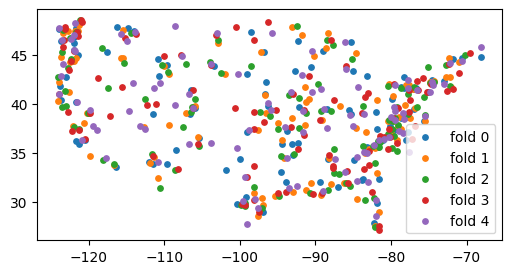

In [6]:
import random
from sklearn.model_selection import GroupKFold,  KFold
def get_group_cv_indices(df_basinid, nfold=5, rndseed=1234567890):

    random.seed(rndseed)
    np.random.seed(rndseed)

    # Initialize GroupKFold
    group_kfold = GroupKFold(n_splits=nfold)

    # Dictionary to store train and test indices
    group_cv_indices = {}

    # Cross-validation process to save indices
    # does not depend on random seeds
    for fold, (train_index, test_index) in enumerate(group_kfold.split(df_basinid, groups=df_basinid['basin_num'])):
        
        train_basin = np.unique(df_basinid.iloc[train_index]['basin_id'].values)
        test_basin = np.unique(df_basinid.iloc[test_index]['basin_id'].values)

        group_cv_indices[fold] = {'train_index': train_index, 'test_index': test_index, 'train_basin': train_basin, 'test_basin': test_basin} 
    return group_cv_indices

# Get the indices
nfold = 5
group_cv_indices = get_group_cv_indices(df_basinid, nfold)

# plot test basin batches
fig = plt.figure(figsize=(6, 3))
for fold in range(len(group_cv_indices)):
    test_basin = group_cv_indices[fold]['test_basin']
    lat = df_basin_info.iloc[test_basin]['lat_cen'].values
    lon = df_basin_info.iloc[test_basin]['lon_cen'].values
    plt.scatter(lon, lat, 15, label=f'fold {fold}')

plt.legend()
plt.show()

# Sklearn Random forest

In [7]:
# evaluation functions
# evaluate

def evaluate_cv(cv_results):
    # evaluation
    rmse_test = np.nan * np.zeros(len(cv_results))
    rmse_train = np.nan * np.zeros(len(cv_results))
    cc_test = np.nan * np.zeros(len(cv_results))
    cc_train = np.nan * np.zeros(len(cv_results))
    
    for fold in range(len(cv_results)):
        y_train, y_test, y_train_pred, y_test_pred = cv_results[fold]['y_train'], cv_results[fold]['y_test'], cv_results[fold]['y_train_pred'], cv_results[fold]['y_test_pred']
        
        # Evaluate the model using 
        rmse_test[fold] = get_rmse(y_test, y_test_pred)
        rmse_train[fold] = get_rmse(y_train, y_train_pred)
        cc_test[fold] = get_cc(y_test, y_test_pred)
        cc_train[fold] = get_cc(y_train, y_train_pred)
            
    return rmse_test, rmse_train, cc_test, cc_train


def get_rmse(d1, d2):
    d1, d2 = np.squeeze(d1), np.squeeze(d2)
    return ( np.nanmean( (d1-d2)**2 ) ) ** 0.5

def get_cc(d1, d2):
    d1, d2 = np.squeeze(d1), np.squeeze(d2)
    ind = ~np.isnan(d1+d2)
    return np.corrcoef(d1[ind], d2[ind])[0,1]




In [8]:
# train the model
def rf_run_cross_validation_parallel(cv_indices, x_all, y_all, ncpus, modelconfig={'n_estimators': 100, 'random_state': 42}):

    if True:

        rf_cv_results = {}
        
        # Cross-validation loop
        for fold, indices in cv_indices.items():
        
            # print(f"RF Fold {fold}")
        
            train_index = indices['train_index']
            test_index = indices['test_index']
            
            x_train, x_test = x_all[train_index], x_all[test_index]
            y_train, y_test = y_all[train_index], y_all[test_index]
            
            # Initialize a new RandomForestRegressor for each fold
            rf_model = RandomForestRegressor(**modelconfig, n_jobs=ncpus)
            
            # Train the model
            rf_model.fit(x_train, y_train)
        
            # Predict on the test set
            y_test_pred = rf_model.predict(x_test)
            y_train_pred = rf_model.predict(x_train)

            if y_test_pred.ndim == 1 and y_test.ndim == 2:
                y_test_pred = y_test_pred[:, np.newaxis]
                y_train_pred = y_train_pred[:, np.newaxis]
            
            
            # Store results
            rf_cv_results[fold] = {
                # 'model': rf_model,
                'train_index': train_index,
                'test_index': test_index,
                'y_train': y_train,
                'y_test': y_test,
                'y_test_pred': y_test_pred,
                'y_train_pred': y_train_pred,
            }
        
    return rf_cv_results


In [9]:

outfile = f'{outpath_all}/LSE_RF_normKGE_groupCV_estimates.pkl'

if os.path.isfile(outfile):
    with open(outfile, 'rb') as file:
        rf_group_cv_results = pickle.load(file)    
else:
    modelconfig = {'n_estimators': 100, 'random_state': 42, 'max_depth': 40}
    rf_group_cv_results = rf_run_cross_validation_parallel(group_cv_indices, x_all, y_all, num_cpus, modelconfig)
    with open(outfile, 'wb') as file:
        pickle.dump(rf_group_cv_results, file)

In [10]:
outfile = f'{outpath_all}/LSE_RF_normKGE_groupCV_evaluation.npz'

if os.path.isfile(outfile):
    dtmp = np.load(outfile)
    rf_group_rmse_train = dtmp['rf_group_rmse_train']
    rf_group_rmse_test = dtmp['rf_group_rmse_test']
    rf_group_cc_train = dtmp['rf_group_cc_train']
    rf_group_cc_test = dtmp['rf_group_cc_test']

else:
    rf_group_rmse_test, rf_group_rmse_train, rf_group_cc_test, rf_group_cc_train = evaluate_cv(rf_group_cv_results)
    np.savez_compressed(outfile, rf_group_rmse_train=rf_group_rmse_train, rf_group_rmse_test=rf_group_rmse_test, rf_group_cc_train=rf_group_cc_train, rf_group_cc_test=rf_group_cc_test)

print(np.mean(rf_group_rmse_test), np.mean(rf_group_rmse_train), np.mean(rf_group_cc_test), np.mean(rf_group_cc_train))

0.24391602268490745 0.020253727711481387 0.6810679989599152 0.9981226722210224


# Sklearn ANN

In [11]:


def bpnn_train_and_evaluate_fold(args):
    fold, indices, x_all, y_all, modelconfig = args
    
    train_index = indices['train_index']
    test_index = indices['test_index']
    
    x_train, x_test = x_all[train_index], x_all[test_index]
    y_train, y_test = y_all[train_index], y_all[test_index]
    
    # Initialize scalers
    x_scaler = StandardScaler()
    y_scaler = StandardScaler()

    # Normalize the input features
    x_train_scaled = x_scaler.fit_transform(x_train)
    x_test_scaled = x_scaler.transform(x_test)
    
    # Normalize the target values
    y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
    y_test_scaled = y_scaler.transform(y_test.reshape(-1, 1)).flatten()

    # Initialize a new MLPRegressor for each fold
    bp_model = MLPRegressor(**modelconfig)
    
    # Train the model
    bp_model.fit(x_train_scaled, y_train_scaled)

    # Predict on the test set
    y_test_pred_scaled = bp_model.predict(x_test_scaled)
    y_train_pred_scaled = bp_model.predict(x_train_scaled)

    # Inverse transform the predicted outputs
    y_test_pred = y_scaler.inverse_transform(y_test_pred_scaled.reshape(-1, 1)).flatten()
    y_train_pred = y_scaler.inverse_transform(y_train_pred_scaled.reshape(-1, 1)).flatten()

    if y_test_pred.ndim == 1 and y_test.ndim == 2:
        y_test_pred = y_test_pred[:, np.newaxis]
        y_train_pred = y_train_pred[:, np.newaxis]
    

    # Store results
    fold_result = {
        'train_index': train_index,
        'test_index': test_index,
        'y_train': y_train,
        'y_test': y_test,
        'y_test_pred': y_test_pred,
        'y_train_pred': y_train_pred,
    }

    return fold, fold_result



def bpnn_run_cross_validation_parallel(cv_indices, x_all, y_all, ncpus, modelconfig={'hidden_layer_sizes': (100,), 'max_iter': 2000, 'alpha': 0.001, 'random_state': 42, 'early_stopping': True}):

    with Pool(processes=ncpus) as pool:
        # Prepare arguments for each fold
        args = [(fold, indices, x_all, y_all, modelconfig) for fold, indices in cv_indices.items()]
            
        # Parallelize the cross-validation loop
        results = pool.map(bpnn_train_and_evaluate_fold, args)
        
        # Collect results
        ann_cv_results = {fold: result for fold, result in results}

    return ann_cv_results


In [14]:
outfile = f'{outpath_all}/LSE_MLP_normKGE_groupCV_estimates.pkl'

if os.path.isfile(outfile):
    with open(outfile, 'rb') as file:
        mlp_group_cv_results = pickle.load(file)
else:
    modelconfig = {'hidden_layer_sizes': (200,), 'max_iter': 1000, 'alpha': 0.0001, 'random_state': 42, 'early_stopping': True, 'validation_fraction': 0.2}
    mlp_group_cv_results = bpnn_run_cross_validation_parallel(group_cv_indices, x_all, y_all, 5, modelconfig)
    with open(outfile, 'wb') as file:
        pickle.dump(mlp_group_cv_results, file)

outfile = f'{outpath_all}/LSE_MLP_normKGE_groupCV_evaluation.npz'

if os.path.isfile(outfile):
    dtmp = np.load(outfile)
    mlp_group_rmse_train = dtmp['mlp_group_rmse_train']
    mlp_group_rmse_test = dtmp['mlp_group_rmse_test']
    mlp_group_cc_train = dtmp['mlp_group_cc_train']
    mlp_group_cc_test = dtmp['mlp_group_cc_test']

else:
    mlp_group_rmse_test, mlp_group_rmse_train, mlp_group_cc_test, mlp_group_cc_train = evaluate_cv(mlp_group_cv_results)
    np.savez_compressed(outfile, mlp_group_rmse_train=mlp_group_rmse_train, mlp_group_rmse_test=mlp_group_rmse_test, mlp_group_cc_train=mlp_group_cc_train, mlp_group_cc_test=mlp_group_cc_test)

print(np.mean(mlp_group_rmse_test), np.mean(mlp_group_rmse_train), np.mean(mlp_group_cc_test), np.mean(mlp_group_cc_train))

0.26663739529229324 0.05850480211377039 0.6875870176010697 0.9838342425395421


In [15]:
suffix = 2

outfile = f'{outpath_all}/LSE_MLP_normKGE_groupCV_estimates{suffix}.pkl'

if os.path.isfile(outfile):
    with open(outfile, 'rb') as file:
        mlp_group_cv_results = pickle.load(file)
else:
    modelconfig = {'hidden_layer_sizes': (100,100,), 'max_iter': 1000, 'alpha': 0.0001, 'random_state': 42, 'early_stopping': True, 'validation_fraction': 0.2}
    mlp_group_cv_results = bpnn_run_cross_validation_parallel(group_cv_indices, x_all, y_all, 5, modelconfig)
    with open(outfile, 'wb') as file:
        pickle.dump(mlp_group_cv_results, file)

outfile = f'{outpath_all}/LSE_MLP_normKGE_groupCV_evaluation{suffix}.npz'

if os.path.isfile(outfile):
    dtmp = np.load(outfile)
    mlp_group_rmse_train = dtmp['mlp_group_rmse_train']
    mlp_group_rmse_test = dtmp['mlp_group_rmse_test']
    mlp_group_cc_train = dtmp['mlp_group_cc_train']
    mlp_group_cc_test = dtmp['mlp_group_cc_test']

else:
    mlp_group_rmse_test, mlp_group_rmse_train, mlp_group_cc_test, mlp_group_cc_train = evaluate_cv(mlp_group_cv_results)
    np.savez_compressed(outfile, mlp_group_rmse_train=mlp_group_rmse_train, mlp_group_rmse_test=mlp_group_rmse_test, mlp_group_cc_train=mlp_group_cc_train, mlp_group_cc_test=mlp_group_cc_test)

print(np.mean(mlp_group_rmse_test), np.mean(mlp_group_rmse_train), np.mean(mlp_group_cc_test), np.mean(mlp_group_cc_train))

0.23495897691096657 0.04710168880948058 0.7155299584565977 0.9895216038321492


# Pytorch ANN training

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np


# Define the neural network model outside the function
class SimpleNN1(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN1, self).__init__()
        self.fc1 = nn.Linear(input_size, 200)
        self.fc2 = nn.Linear(200, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

    # Add a predict method similar to sklearn's
    def predict(self, X):
        if isinstance(X, np.ndarray):
            X = torch.tensor(X, dtype=torch.float32)

        self.eval()  # Set model to evaluation mode
        with torch.no_grad():  # Disable gradient calculation
            predictions = self.forward(X)
        return predictions.numpy()  # Convert the predictions back to numpy


class SimpleNN2(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN2, self).__init__()
        # Update to two hidden layers with 100 units each
        self.fc1 = nn.Linear(input_size, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 1)  # Output layer

    def forward(self, x):
        # Pass through the two hidden layers
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)  # Final output

    # Add a predict method similar to sklearn's
    def predict(self, X):
        if isinstance(X, np.ndarray):
            X = torch.tensor(X, dtype=torch.float32)

        self.eval()  # Set model to evaluation mode
        with torch.no_grad():  # Disable gradient calculation
            predictions = self.forward(X)
        return predictions.numpy()  # Convert the predictions back to numpy

def train_nn_model_pytorch(x_train_scaled, y_train, x_val_scaled, y_val, n_epochs=1000, patience=10, lr=0.001, model_file="model.pth", method=1):
    # Convert data to PyTorch tensors
    x_train_tensor = torch.tensor(x_train_scaled, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
    x_val_tensor = torch.tensor(x_val_scaled, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

    # Initialize the model, loss function, and optimizer
    if method==1:
        model = SimpleNN1(input_size=x_train_tensor.shape[1])
    elif method==2:
        model = SimpleNN2(input_size=x_train_tensor.shape[1])
    criterion = nn.MSELoss()  # We use MSELoss but will take the sqrt for RMSE
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Early stopping parameters
    best_val_rmse = float('inf')
    best_train_rmse = float('inf')
    patience_counter = 0

    # Training loop
    for epoch in range(n_epochs):
        # Training phase
        model.train()
        optimizer.zero_grad()
        predictions = model(x_train_tensor)
        train_loss = criterion(predictions, y_train_tensor)
        train_loss.backward()
        optimizer.step()

        # Calculate RMSE for training
        train_rmse = torch.sqrt(train_loss).item()

        # Validation phase
        model.eval()
        with torch.no_grad():
            val_predictions = model(x_val_tensor)
            val_loss = criterion(val_predictions, y_val_tensor)
            val_rmse = torch.sqrt(val_loss).item()  # Calculate RMSE for validation

        # Early stopping logic based on validation RMSE
        if val_rmse < best_val_rmse:
            best_val_rmse = val_rmse
            best_train_rmse = train_rmse  # Update best train RMSE when validation RMSE improves
            patience_counter = 0
            torch.save(model.state_dict(), model_file)  # Save the best model
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print('Early stopping triggered.')
            break

    # Load the best model state before returning
    model.load_state_dict(torch.load(model_file))

    # Output the best validation and training RMSE after training finishes
    print(f'Best Training RMSE after training: {best_train_rmse}')
    print(f'Best Validation RMSE after training: {best_val_rmse}')
    print(f'Best Training MSE after training: {best_train_rmse**2}')
    print(f'Best Validation MSE after training: {best_val_rmse**2}')

    # Return the trained model, now with predict method
    return model


In [22]:

# Train a random forest emulator
outfile = f'{outpath_all}/Pytorch_ANN_emulator1'
em_model = train_nn_model_pytorch(x_train_scaled, y_train, x_val_scaled, y_val, model_file=outfile, method=2)


Early stopping triggered.
Best Training RMSE after training: 0.15986594557762146
Best Validation RMSE after training: 0.23128218948841095
Best Training MSE after training: 0.025557120555427026
Best Validation MSE after training: 0.05349145117455323


/glade/derecho/scratch/guoqiang/tmp/ipykernel_40458/134617902.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_file))


In [23]:
fold = 0
train_index=group_cv_indices[fold]
test_index=group_cv_indices[fold]


# Pytorch ANN, mimicing sklearn

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
from multiprocessing import Pool

# Define the neural network model
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_layers=(100, 100)):
        super(SimpleNN, self).__init__()
        layers = []
        prev_size = input_size
        for hidden_size in hidden_layers:
            layers.append(nn.Linear(prev_size, hidden_size))
            layers.append(nn.ReLU())
            prev_size = hidden_size
        layers.append(nn.Linear(prev_size, 1))  # Output layer
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

    def predict(self, X):
        if isinstance(X, np.ndarray):
            X = torch.tensor(X, dtype=torch.float32)
        self.eval()  # Set model to evaluation mode
        with torch.no_grad():  # Disable gradient calculation
            predictions = self.forward(X)
        return predictions.numpy()  # Convert the predictions back to numpy


def train_nn_model_pytorch_fold(args):
    fold, indices, x_all, y_all, n_epochs, patience, lr, model_file = args
    
    # Extract training and testing indices for the fold
    train_index = indices['train_index']
    test_index = indices['test_index']
    
    x_train, x_test = x_all[train_index], x_all[test_index]
    y_train, y_test = y_all[train_index], y_all[test_index]

    # Initialize scalers for inputs and outputs
    x_scaler = StandardScaler()
    y_scaler = StandardScaler()

    # Normalize x_train and x_test
    x_train_scaled = x_scaler.fit_transform(x_train)
    x_test_scaled = x_scaler.transform(x_test)

    # Normalize y_train and y_test
    y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
    y_test_scaled = y_scaler.transform(y_test.reshape(-1, 1)).flatten()

    # Convert data to PyTorch tensors
    x_train_tensor = torch.tensor(x_train_scaled, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32).view(-1, 1)
    x_test_tensor = torch.tensor(x_test_scaled, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32).view(-1, 1)

    # Initialize the model, loss function, and optimizer
    model = SimpleNN(input_size=x_train_tensor.shape[1])
    criterion = nn.MSELoss()  # We use MSELoss but will take the sqrt for RMSE
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Early stopping parameters
    best_val_rmse = float('inf')
    best_train_rmse = float('inf')
    patience_counter = 0

    # Training loop with internal random validation split
    for epoch in range(n_epochs):
        # Randomly split 10% of the training data as validation
        x_train_fold, x_val_fold, y_train_fold, y_val_fold = train_test_split(
            x_train_tensor, y_train_tensor, test_size=0.2, random_state=epoch
        )

        # Training phase
        model.train()
        optimizer.zero_grad()
        predictions = model(x_train_fold)
        train_loss = criterion(predictions, y_train_fold)
        train_loss.backward()
        optimizer.step()

        # Calculate RMSE for training
        train_rmse = torch.sqrt(train_loss).item()

        # Validation phase
        model.eval()
        with torch.no_grad():
            val_predictions = model(x_val_fold)
            val_loss = criterion(val_predictions, y_val_fold)
            val_rmse = torch.sqrt(val_loss).item()  # Calculate RMSE for validation

        # Early stopping logic based on validation RMSE
        if val_rmse < best_val_rmse:
            best_val_rmse = val_rmse
            best_train_rmse = train_rmse  # Update best train RMSE when validation RMSE improves
            patience_counter = 0
            torch.save(model.state_dict(), model_file)  # Save the best model
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f'Fold {fold}: Early stopping triggered.')
            break

    # Load the best model state
    model.load_state_dict(torch.load(model_file))

    # Testing phase (on 20% test set)
    model.eval()
    with torch.no_grad():
        test_predictions_scaled = model(x_test_tensor)
        train_predictions_scaled = model(x_train_tensor)  # Predict on training set for train results

    # Inverse transform the scaled predictions and true values for interpretability
    y_test_pred = y_scaler.inverse_transform(test_predictions_scaled.numpy().flatten().reshape(-1, 1)).flatten()
    y_train_pred = y_scaler.inverse_transform(train_predictions_scaled.numpy().flatten().reshape(-1, 1)).flatten()
    y_test_true = y_test  # Original unscaled y_test values
    y_train_true = y_train  # Original unscaled y_train values

    # Store results
    fold_result = {
        'train_index': train_index,
        'test_index': test_index,
        'y_train': y_train_true,
        'y_test': y_test_true,
        'y_test_pred': y_test_pred,
        'y_train_pred': y_train_pred,
        'train_rmse': best_train_rmse,
        'val_rmse': best_val_rmse,
    }
    return fold, fold_result


def run_cross_validation_pytorch(cv_indices, x_all, y_all, ncpus, n_epochs=1000, patience=10, lr=0.001):
    model_file = "model_fold.pth"
    # Prepare arguments for each fold
    args = [
        (fold, indices, x_all, y_all, n_epochs, patience, lr, model_file)
        for fold, indices in cv_indices.items()
    ]

    # Run cross-validation in parallel
    with Pool(processes=ncpus) as pool:
        results = pool.map(train_nn_model_pytorch_fold, args)

    # Collect and organize results by fold
    ann_cv_results = {fold: result for fold, result in results}

    return ann_cv_results


In [18]:
outfile = f'{outpath_all}/LSE_PytorchNN_normKGE_groupCV_estimates.pkl'

if os.path.isfile(outfile):
    with open(outfile, 'rb') as file:
        mlp_group_cv_results = pickle.load(file)
else:
    mlp_group_cv_results = run_cross_validation_pytorch(group_cv_indices, x_all, y_all, 5)
    with open(outfile, 'wb') as file:
        pickle.dump(mlp_group_cv_results, file)

outfile = f'{outpath_all}/LSE_PytorchNN_normKGE_groupCV_evaluation.npz'

if os.path.isfile(outfile):
    dtmp = np.load(outfile)
    mlp_group_rmse_train = dtmp['mlp_group_rmse_train']
    mlp_group_rmse_test = dtmp['mlp_group_rmse_test']
    mlp_group_cc_train = dtmp['mlp_group_cc_train']
    mlp_group_cc_test = dtmp['mlp_group_cc_test']

else:
    mlp_group_rmse_test, mlp_group_rmse_train, mlp_group_cc_test, mlp_group_cc_train = evaluate_cv(mlp_group_cv_results)
    np.savez_compressed(outfile, mlp_group_rmse_train=mlp_group_rmse_train, mlp_group_rmse_test=mlp_group_rmse_test, mlp_group_cc_train=mlp_group_cc_train, mlp_group_cc_test=mlp_group_cc_test)

print(np.mean(mlp_group_rmse_test), np.mean(mlp_group_rmse_train), np.mean(mlp_group_cc_test), np.mean(mlp_group_cc_train))

0.12494849919975075 0.1426924282762719 0.9020818806453311 0.8965373676612751


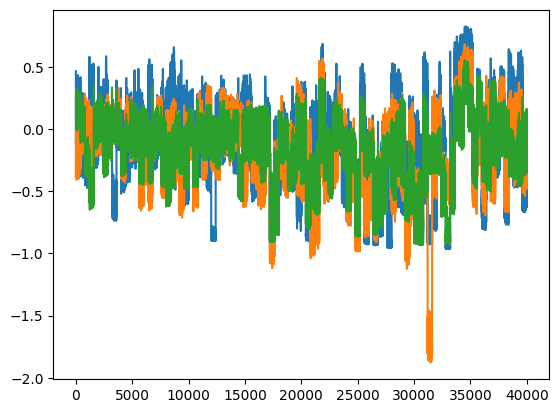

In [19]:
d1 = np.squeeze(mlp_group_cv_results[0]['y_test'])
d2 = np.squeeze(mlp_group_cv_results[0]['y_test_pred'])
d3 = np.squeeze(rf_group_cv_results[0]['y_test_pred'])

plt.plot(d1)
plt.plot(d2)
plt.plot(d3)

# Train Pytorch using all samples

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# Define the neural network model
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_layers=(100, 100)):
        super(SimpleNN, self).__init__()
        layers = []
        prev_size = input_size
        for hidden_size in hidden_layers:
            layers.append(nn.Linear(prev_size, hidden_size))
            layers.append(nn.ReLU())
            prev_size = hidden_size
        layers.append(nn.Linear(prev_size, 1))  # Output layer
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

    def predict(self, X):
        if isinstance(X, np.ndarray):
            X = torch.tensor(X, dtype=torch.float32)
        self.eval()  # Set model to evaluation mode
        with torch.no_grad():  # Disable gradient calculation
            predictions = self.forward(X)
        return predictions.numpy()  # Convert the predictions back to numpy


def train_nn_model_pytorch(x_all, y_all, n_epochs=2000, patience=30, lr=0.0005, model_file="model.pth"):
    # Split the data into training and validation sets (10% for validation)
    x_train, x_val, y_train, y_val = train_test_split(
        x_all, y_all, test_size=0.1, random_state=42
    )

    # Initialize scalers for inputs and outputs
    x_scaler = StandardScaler()
    y_scaler = StandardScaler()

    # Normalize x_train and x_val
    x_train_scaled = x_scaler.fit_transform(x_train)
    x_val_scaled = x_scaler.transform(x_val)

    # Normalize y_train and y_val
    y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
    y_val_scaled = y_scaler.transform(y_val.reshape(-1, 1)).flatten()

    # Convert data to PyTorch tensors
    x_train_tensor = torch.tensor(x_train_scaled, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32).view(-1, 1)
    x_val_tensor = torch.tensor(x_val_scaled, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val_scaled, dtype=torch.float32).view(-1, 1)

    # Initialize the model, loss function, and optimizer
    model = SimpleNN(input_size=x_train_tensor.shape[1])
    criterion = nn.MSELoss()  # We use MSELoss but will calculate RMSE manually
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Early stopping parameters
    best_val_rmse = float('inf')
    patience_counter = 0

    # Training loop
    for epoch in range(n_epochs):
        # Training phase
        model.train()
        optimizer.zero_grad()
        predictions = model(x_train_tensor)
        train_loss = criterion(predictions, y_train_tensor)
        train_loss.backward()
        optimizer.step()

        # Calculate train RMSE from model predictions
        train_predictions = model.predict(x_train_scaled)
        train_rmse = np.sqrt(np.mean((y_scaler.inverse_transform(train_predictions) - y_train) ** 2))

        # Validation phase
        model.eval()
        with torch.no_grad():
            val_predictions = model.predict(x_val_scaled)
            val_rmse = np.sqrt(np.mean((y_scaler.inverse_transform(val_predictions) - y_val) ** 2))

        # Print RMSE for each epoch
        print(f'Epoch {epoch+1}, Training RMSE: {train_rmse:.4f}, Validation RMSE: {val_rmse:.4f}')

        # Early stopping logic based on validation RMSE
        if val_rmse < best_val_rmse:
            best_val_rmse = val_rmse
            best_train_rmse = train_rmse  # Update best train RMSE when validation RMSE improves
            patience_counter = 0
            torch.save(model.state_dict(), model_file)  # Save the best model
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print('Early stopping triggered.')
            break

    # Load the best model state before returning
    model.load_state_dict(torch.load(model_file))

    # Output the best validation and training RMSE after training finishes
    print(f'Best Training RMSE after training: {best_train_rmse}')
    print(f'Best Validation RMSE after training: {best_val_rmse}')

    # Return the trained model, now with predict method
    return model


In [25]:
model = train_nn_model_pytorch(x_all, y_all)

Epoch 1, Training RMSE: 0.3285, Validation RMSE: 0.3274
Epoch 2, Training RMSE: 0.3247, Validation RMSE: 0.3236
Epoch 3, Training RMSE: 0.3211, Validation RMSE: 0.3199
Epoch 4, Training RMSE: 0.3176, Validation RMSE: 0.3164
Epoch 5, Training RMSE: 0.3141, Validation RMSE: 0.3129
Epoch 6, Training RMSE: 0.3108, Validation RMSE: 0.3095
Epoch 7, Training RMSE: 0.3075, Validation RMSE: 0.3062
Epoch 8, Training RMSE: 0.3042, Validation RMSE: 0.3030
Epoch 9, Training RMSE: 0.3010, Validation RMSE: 0.2998
Epoch 10, Training RMSE: 0.2978, Validation RMSE: 0.2966
Epoch 11, Training RMSE: 0.2947, Validation RMSE: 0.2935
Epoch 12, Training RMSE: 0.2916, Validation RMSE: 0.2904
Epoch 13, Training RMSE: 0.2885, Validation RMSE: 0.2873
Epoch 14, Training RMSE: 0.2854, Validation RMSE: 0.2843
Epoch 15, Training RMSE: 0.2824, Validation RMSE: 0.2813
Epoch 16, Training RMSE: 0.2795, Validation RMSE: 0.2783
Epoch 17, Training RMSE: 0.2766, Validation RMSE: 0.2754
Epoch 18, Training RMSE: 0.2737, Validat

/glade/derecho/scratch/guoqiang/tmp/ipykernel_70632/310533576.py:103: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_file))


# Sklearn ANN using x_all

In [20]:
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

def train_nn_model_sklearn(x_all, y_all, hidden_layers=(100, 100), max_iter=1000, patience=10, random_state=42):
    # Split the data into training and validation sets (10% for validation)
    x_train, x_val, y_train, y_val = train_test_split(
        x_all, y_all, test_size=0.1, random_state=random_state
    )

    # Initialize scalers for inputs and outputs
    x_scaler = StandardScaler()
    y_scaler = StandardScaler()

    # Normalize x_train and x_val
    x_train_scaled = x_scaler.fit_transform(x_train)
    x_val_scaled = x_scaler.transform(x_val)

    # Normalize y_train and y_val
    y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
    y_val_scaled = y_scaler.transform(y_val.reshape(-1, 1)).flatten()

    # Initialize the MLPRegressor with early stopping
    model = MLPRegressor(
        hidden_layer_sizes=hidden_layers,
        max_iter=max_iter,
        early_stopping=True,  # Enables internal validation-based early stopping
        validation_fraction=0.1,  # Internal validation on 10% of the training set for early stopping
        n_iter_no_change=patience,  # Stops if no improvement for 'patience' epochs
        random_state=random_state,
        solver="adam"
    )

    # Train the model
    model.fit(x_train_scaled, y_train_scaled)

    # Calculate RMSE on the validation set using model predictions
    y_train_pred_scaled = model.predict(x_train_scaled)
    y_val_pred_scaled = model.predict(x_val_scaled)

    # Inverse transform the predicted and actual values to calculate RMSE in original scale
    y_train_pred = y_scaler.inverse_transform(y_train_pred_scaled.reshape(-1, 1)).flatten()
    y_val_pred = y_scaler.inverse_transform(y_val_pred_scaled.reshape(-1, 1)).flatten()
    y_train_true = y_train
    y_val_true = y_val

    train_rmse = np.sqrt(mean_squared_error(y_train_true, y_train_pred))
    val_rmse = np.sqrt(mean_squared_error(y_val_true, y_val_pred))

    # Output the best training and validation RMSE after training finishes
    print(f'Best Training RMSE: {train_rmse}')
    print(f'Best Validation RMSE: {val_rmse}')

    # Return the trained model and scalers for further predictions
    return model, x_scaler, y_scaler


In [21]:
train_nn_model_sklearn(x_all, y_all)

Best Training RMSE: 0.04352850613978999
Best Validation RMSE: 0.048807726740472394


(MLPRegressor(early_stopping=True, hidden_layer_sizes=(100, 100), max_iter=1000,
              random_state=42),
 StandardScaler(),
 StandardScaler())